## pya Aserver test

In [7]:
import numpy as np
import time
from pya import *

In [8]:
pya.startup(bs=1024)  # start the default server kwargs are forwarded...

Aserver default_server already set.


which basically calls Aserver.startup_default_server()

In [3]:
# load an Asig from wav file
asnap = Asig("samples/snap.wav", label='snap');

/Users/jiajunyang/anaconda3/envs/pya/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Asig('snap'): 1 x 41216 @ 44100 Hz = 0.935 s

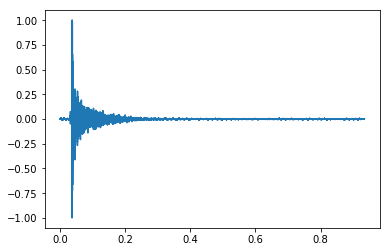

In [5]:
asnap.plot()

In [6]:
# Asig play now uses default server
asnap[0:2000].play(0.2, onset=0.5, out=0)
asnap.gain(db=10).play(1, onset=1, out=1)

Asig('snap_sliced_resampled'): 1 x 10000 @ 44100 Hz = 0.227 s
Asig('snap_scaled'): 1 x 41216 @ 44100 Hz = 0.935 s


Asig('snap_scaled'): 1 x 41216 @ 44100 Hz = 0.935 s

In [ ]:
pya.shutdown()

or: create your own server (you can have as many as you want running simultaneously)

In [ ]:
s = Aserver(sr=44100, bs=256, device=1, channels=2, format=pyaudio.paFloat32)
s.boot()

In [ ]:
asnap[0:2000].play(0.2, onset=0.5, out=0, server=s)
asnap.play(1, onset=1, out=1, server=s)  

In [ ]:
# since we have shutdown the default server we get an error now
asnap.gain(0.3).play(0.3);

In [ ]:
# but we can restart the default server any time
pya.startup()

In [ ]:
# this demonstrates playing signals via the Server instance directly
# play mono signal left and right
s.play(asnap, onset=0.0, out=0)  
s.play(asnap, onset=0.5, out=1)  

In [ ]:
t = time.time()
for k in range(20):
    r = 1; # linlin(np.random.random(), 0, 1, 0.2, 0.5)
    onset = t + linlin(k, 0, 20, 0, 5)
    # level = linlin(np.random.random(), 0, 20, -20, -40)
    # s.play(asnap.resample(rate=r).gain(db=level), onset=onset)
    s.play(asnap, onset=onset, out=k%2)
print(time.time()-t)

In [ ]:
# currently _play_callback estimates nominal time from nr. of blocks and sr
# timejitter stores the current delta -- let's see if this goes of on longer runtimes...
s.timejitter

In [ ]:
# these are the currently scheduled onsets of asigs in srv_asigs
s.srv_onsets

In [ ]:
# quit and delete server...
# s.quit()
# del(s)

## pyaudio direct interaction test

In [ ]:
import pyaudio

In [ ]:
p = pyaudio.PyAudio()

In [ ]:
nr_devices = p.get_device_count()
for i in range(nr_devices):
    d = p.get_device_info_by_index(i)
    print(f"{i}: {d['name']:20} in={d['maxInputChannels']},\
        out={d['maxOutputChannels']}, sr={d['defaultSampleRate']}")          

In [ ]:
p.get_device_info_by_index(2)['maxOutputChannels']

In [ ]:
ch = 2
def callback(in_data, frame_count, time_info, status):
    t = np.linspace(0, 2048/22050, 2048)
    data = (np.sin(2*np.pi*350*t)*0.1).astype('float32')
    #data = (np.random.rand(ch, frame_count)).astype('float32')
    return (data, pyaudio.paContinue)

In [ ]:
stream = p.open(format=pyaudio.paFloat32,     #pyaudio.paInt16,
            channels=1,
            rate=22050,
            output=True,
            frames_per_buffer=2048,
            stream_callback=callback)

In [ ]:
stream.start_stream()

In [ ]:
stream.stop_stream()
stream.is_active()

In [ ]:
stream.close()

In [ ]:
p.terminate()

# profiling: what method is fastest to administer srv_lists

* in _play_callback, I use lists for onset, asigs, out, curpos to be fast, 
* but is there a faster way to do it? dicts? classes? list of lists?, let's see:

In [ ]:
%%timeit
# my current Aserver solutions
la = []
lb = []
lc = []
for i in range(1000):
    la.append(0)
    lb.append(0)
    lc.append(0)    
for k in range(1000):
    for i in range(1000):
        la[i] += 1
        lb[i] += 2
for i in range(1000):
    del la[0]
    del lb[0]
    del lc[0]

In [ ]:
%%timeit
# alternatively a list of lists for the parameters
l = []
for i in range(1000):
    l.append([0,0,0])
for k in range(1000):
    for i in range(1000):
        l[i][0] += 1
        l[i][1] += 2
for i in range(1000):
    del l[0]

In [ ]:
# here, if a class would be taken
class my:
    def __init__(self):
        self.a = 0
        self.b = 0
        self.c = 0

In [ ]:
%%timeit
l = []
for i in range(1000):
    l.append(my())
for k in range(1000):
    for i in range(1000):
        l[i].a  += 1
        l[i].b  += 2
for i in range(1000):
    l[i]

In [ ]:
%%timeit
# here how fast a dict is, using strings as keys
l = []
for i in range(1000):
    l.append({'aasdf': 0, 'basdf': 0, 'casdf': 0})
for k in range(1000):
    for i in range(1000):
        l[i]['aasdf'] += 1
        l[i]['basdf'] += 2
for i in range(1000):
    del l[0]

* conclusion: my initial guess is the fastest (though perhaps not the most elegant...)